## Initialising model and libraries

In [48]:
import sys
sys.path.append('../')
import torch
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM,BioSRMicrotubules,BioSRFActin
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
from torch.nn.functional import interpolate
import numpy as np
from pytorch_lightning import seed_everything
import math
import seaborn as sns
import matplotlib.pyplot as plt

from torch.nn.functional import avg_pool3d
trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/MNIST/mamba/sum/Mamba_MNIST_wp_1000_sum_L_8_H_8_s_10_subset_False_23-05_11-56-51/epoch=192-step=165980.ckpt'

dataset = trained_model_path.split('/')[-5]
model_type = trained_model_path.split('/')[-4]
loss = trained_model_path.split('/')[-3]
# dataset = "MNIST"
# model_type = 'mamba'
# loss = 'sum'
dataset = "CelebA"
seed_everything(22122020)

if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=32, subset_flag=False)
if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=64, subset_flag=False)
if dataset == "Bio":
    dm = BioSRFActin('./', 8)
# dm = BioSRMicrotubules('./', 8)
dm.prepare_data()
dm.setup()
r, phi, flatten_order, order, fc_per_ring = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss=loss,
                              w_phi = 1000,
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells = 8,
                              model_type = model_type,
                              fc_per_ring=fc_per_ring).cuda()


# weights = torch.load(trained_model_path)['state_dict']
# model.load_state_dict(weights, strict=True)
model.cuda()
model.eval()

print('Model Loaded')

Seed set to 22122020


Model Loaded


In [52]:
for fc, (mag_min, mag_max), img in dm.train_dataloader():
        break

In [8]:
import time

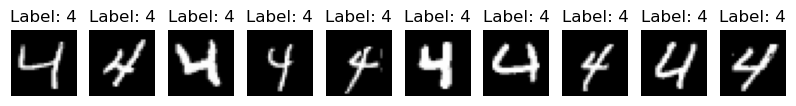

In [26]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a transform to convert the images to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter the dataset to only include images of 1s
ones_indices = [i for i, (img, label) in enumerate(mnist) if label == 4]

# Create a subset of the dataset with only 1s
ones_subset = torch.utils.data.Subset(mnist, ones_indices)

# Function to display a few images from the dataset
def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Display a few images of 1s
show_images(ones_subset)


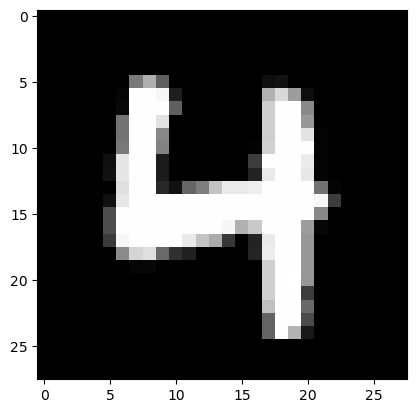

In [43]:
img, label = ones_subset[18]
plt.imshow(img.squeeze(), cmap='gray')

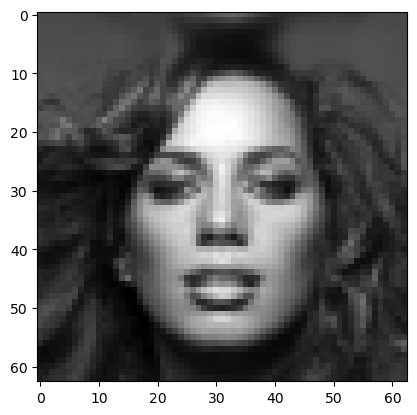

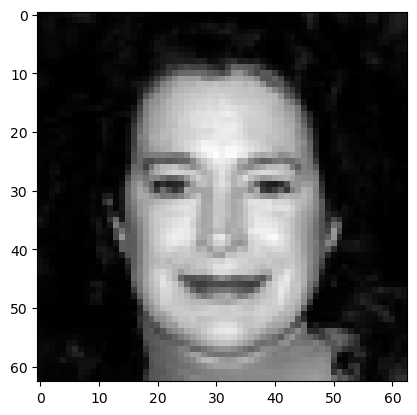

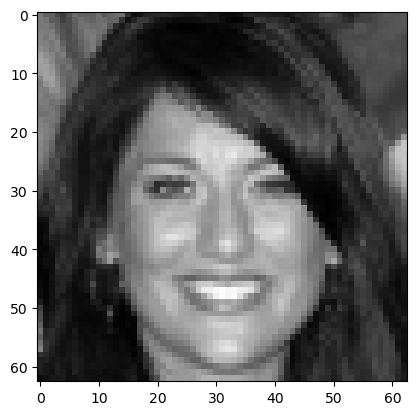

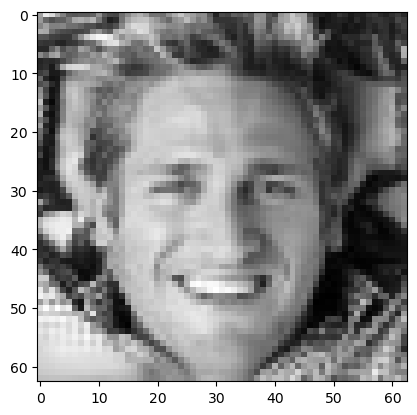

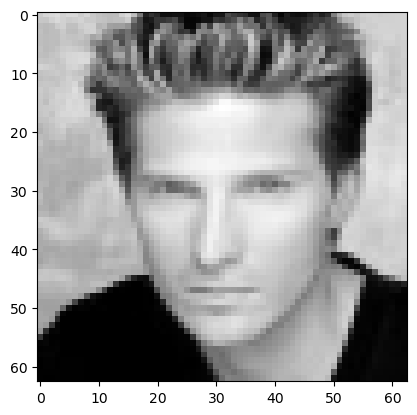

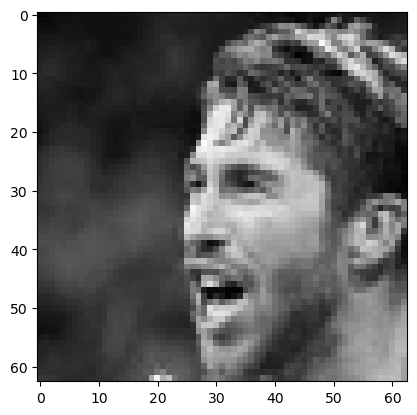

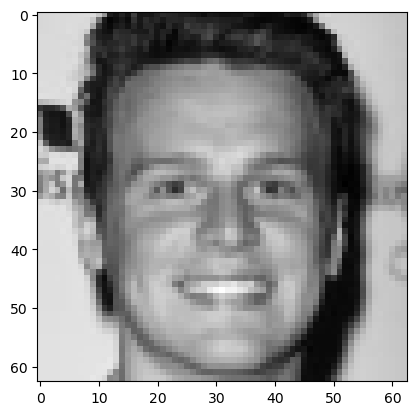

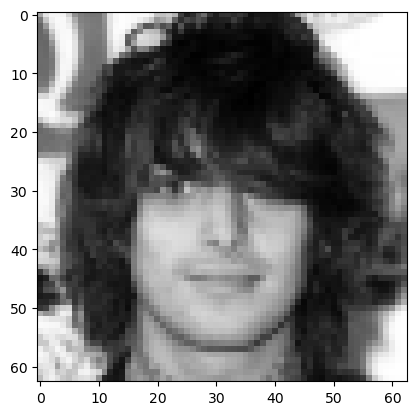

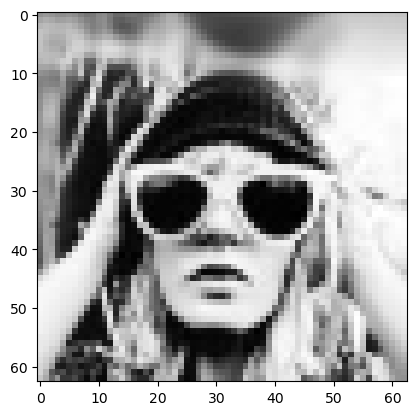

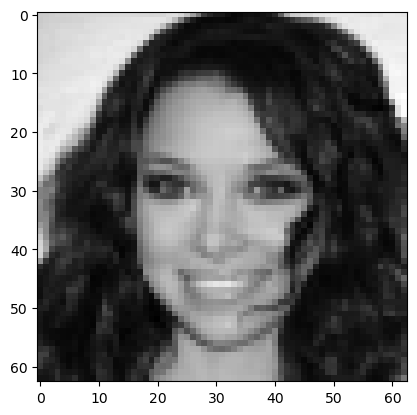

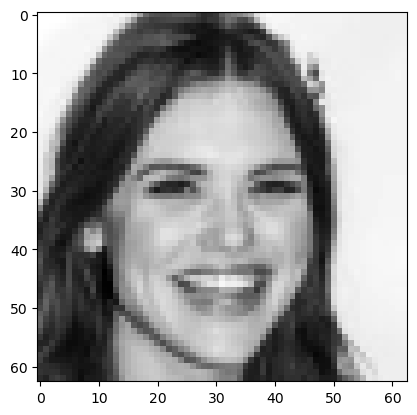

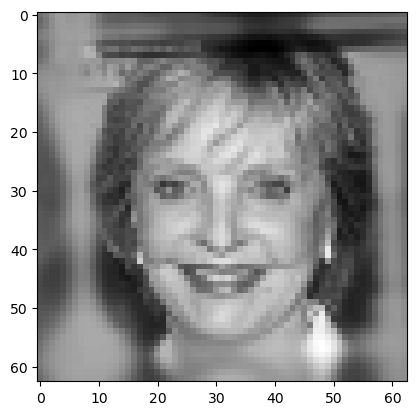

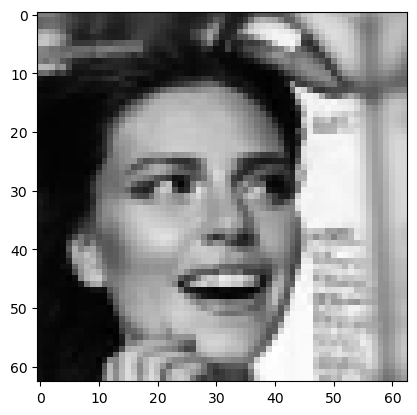

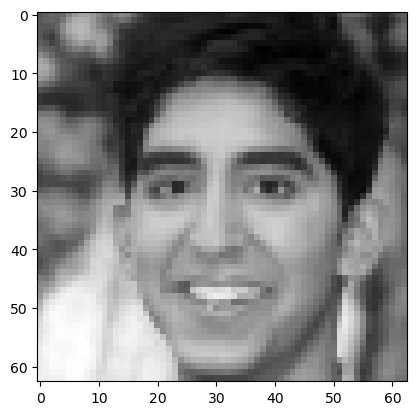

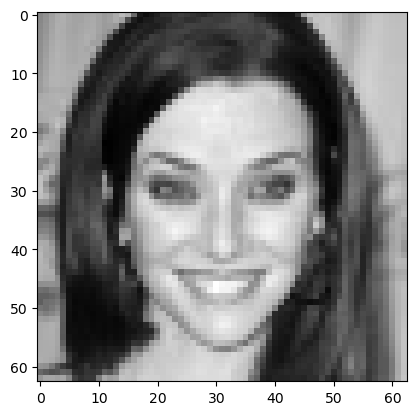

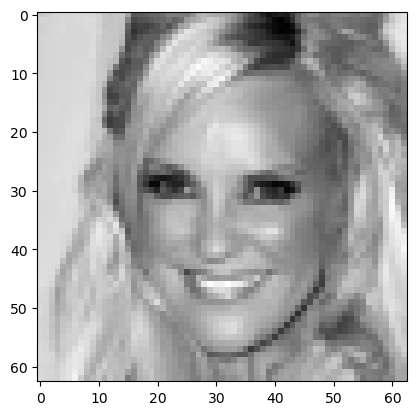

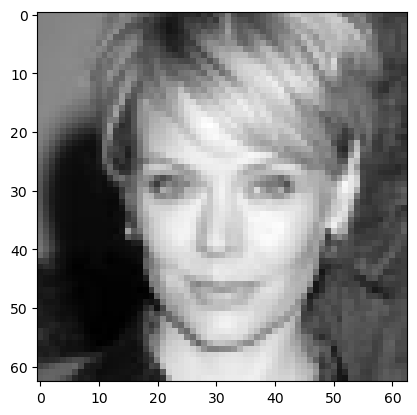

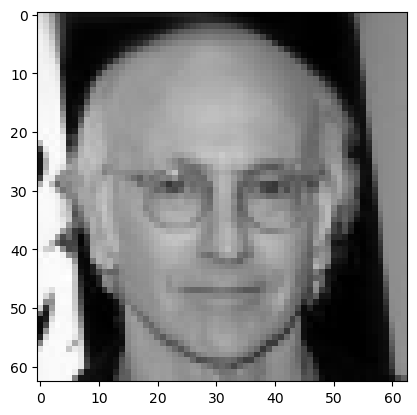

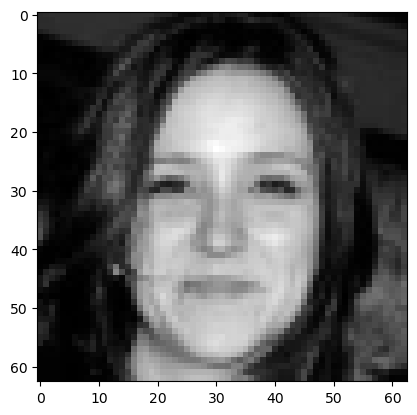

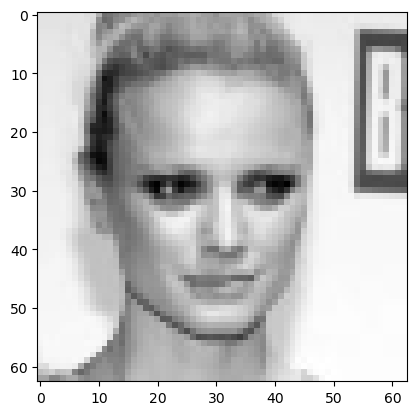

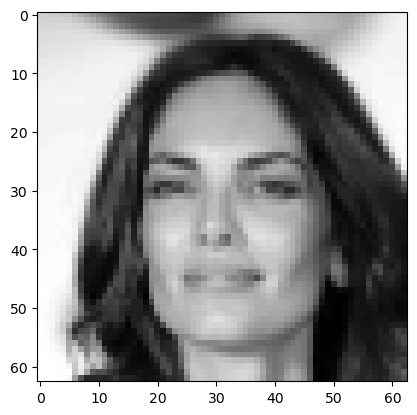

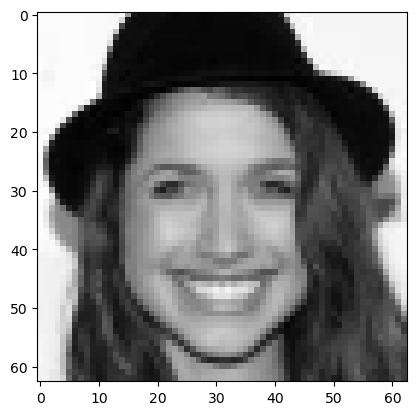

In [53]:
plt.figure();
for i in range(10,32):
    plt.imshow(img[i].cpu().numpy(), cmap='gray')
    plt.show()


In [79]:
for fc, (mag_min, mag_max), img in dm.train_dataloader():
        break
fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
fc = fc[:,model.dst_flatten_order]

interpolated_fc = model.sres.get_interpolated_rings(fc) # 32,378,2 --> 32,2,19,50

if model.sres.semicircle_only_flag:
        input_ = model.sres.get_largest_semicircle(interpolated_fc).permute(0,2,-1,1)  #32,19,50,2 --> 32,14,50,2

else:
        input_ = interpolated_fc.clone().permute(0,2,-1,1)  #32,19,50,2 

embedded_tensor = model.sres.embed_tensor(input_) #32,19,50,2 --> 32,95,128

# embedded_tensor_positional = model.sres.pos_embedding(embedded_tensor) #32,95,128 --> 32,95,256 

# encoder_output = model.sres.encoder_forward(embedded_tensor_positional) #32,95,256 --> 32,95,256

# pred = torch.cat([input_.reshape(*input_.shape[:1],-1,model.sres.no_of_sectors,2)[:,:1,:,:],encoder_output[:,:-1,:,:]], dim=1) #32,1,10,1 + 32,94,10,1 --> 32,95,10,2

if model.sres.semicircle_only_flag:
        pred = model.sres.get_full_plane_from_sectors(pred,interpolated_fc)
else:
        pred = pred.reshape(pred.shape[0],-1,model.sres.interpolation_size,2).permute(0,3,1,2) #32,95,10,2 --> 32,19,50,2 --> 32,2,19,50

model_output = model.sres.get_de_interpolated_rings(pred)


torch.Size([32, 378, 2])

In [11]:
y_amp = torch.tanh(model.sres.predictor_amp(y_hat[...,:y_hat.shape[-1]//2]))
y_phase = torch.tanh(model.sres.predictor_phase(y_hat[...,y_hat.shape[-1]//2:]))

In [19]:
torch.cat([y_amp.reshape(32,14,5,10).unsqueeze(-1), y_phase.reshape(32,14,5,10).unsqueeze(-1)],dim = -1).reshape(32,14,50,2).shape


torch.Size([32, 14, 50, 2])

In [21]:
rnn = torch.nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
output, hn = rnn(input)

In [23]:
output.shape

torch.Size([5, 3, 20])

In [46]:
for fc, (mag_min, mag_max) in dm.train_dataloader():
        break
from transformers import RoFormerForCausalLM

# Initializing a RoFormer junnyu/roformer_chinese_base style configuration
conf = RoFormerConfig()
conf.embedding_size = 128
# Initializing a model (with random weights) from the junnyu/roformer_chinese_base style configuration

model = RoFormerModel(conf)
model.embeddings.word_embeddings = torch.nn.Linear(2,128)
# Accessing the model configuration
conf

RoFormerConfig {
  "attention_probs_dropout_prob": 0.1,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 1536,
  "model_type": "roformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "rotary_value": false,
  "transformers_version": "4.40.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

In [52]:
from operator import is_


RoFormerForCausalLM(conf)

If you want to use `RoFormerForCausalLM` as a standalone, add `is_decoder=True.`


RoFormerForCausalLM(
  (roformer): RoFormerModel(
    (embeddings): RoFormerEmbeddings(
      (word_embeddings): Embedding(50000, 128, padding_idx=0)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=768, bias=True)
    (encoder): RoFormerEncoder(
      (embed_positions): RoFormerSinusoidalPositionalEmbedding(1536, 64)
      (layer): ModuleList(
        (0-11): 12 x RoFormerLayer(
          (attention): RoFormerAttention(
            (self): RoFormerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RoFormerSelfOutput(
      

In [7]:
fc[0,:,0]

tensor([0.8555, 0.0000])

In [63]:
DeConv_Layer(DeConv_input.view(8,45,-1,2).unsqueeze(-1))

torch.Size([8, 45, 100, 2, 1])

In [ ]:
y_enc_out = y_enc_out.permute(0,2,1).unsqueeze(-1)

In [37]:
Intrapolated.unsqueeze(-1).shape

torch.Size([8, 45, 100, 2, 1])

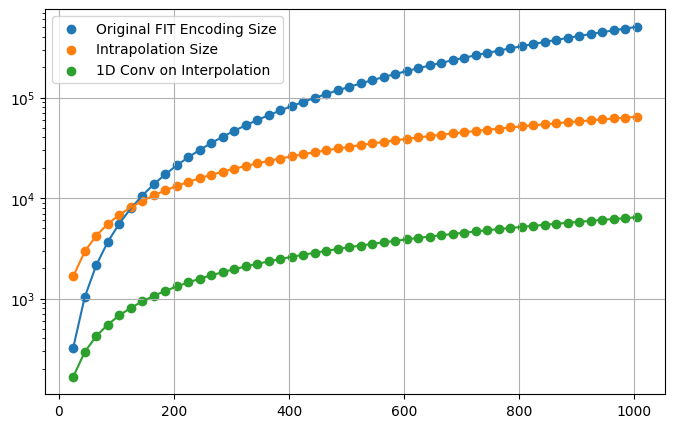

In [27]:
L = np.arange(25,1020,20)
k = 10
s = 10
r = (L//2)+1
E = 128

plt.figure(figsize=(8,5))
plt.plot(L,L*r)
plt.scatter(L,(L*r), label = 'Original FIT Encoding Size')

plt.plot(L,r*E)
plt.scatter(L,r*E,label = 'Intrapolation Size')

plt.plot(L,r*(E-k+s)/s)
plt.scatter(L,r*((E-k+s)/s), label = '1D Conv on Interpolation')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

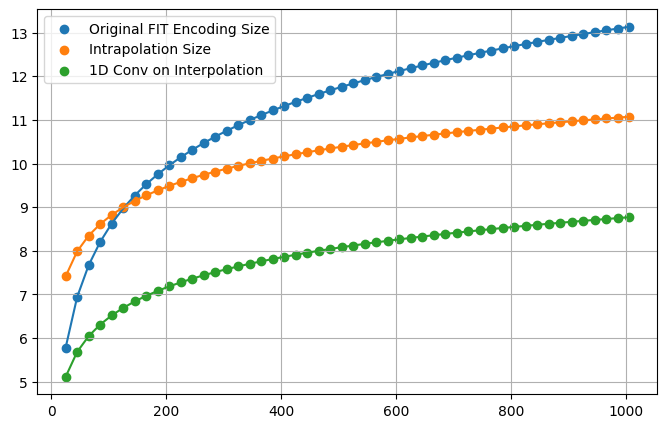

In [24]:
L = np.arange(25,1020,20)
k = 10
s = 10
r = (L//2)+1
E = 128
plt.figure(figsize=(8,5))
plt.plot(L,np.log(L*r))
plt.scatter(L,np.log((L*r)), label = 'Original FIT Encoding Size')

plt.plot(L,np.log(r*E))
plt.scatter(L,np.log(r*E),label = 'Intrapolation Size')

plt.plot(L,np.log(r*(E-k+s)/s))
plt.scatter(L,np.log(r*((E-k+s)/s)), label = '1D Conv on Interpolation')

plt.legend()
plt.grid()
plt.show()

Comparing if mean value of fc is changed when applying Interpolation


torch.Size([32, 2, 47])
torch.Size([32, 47])
torch.Size([47])


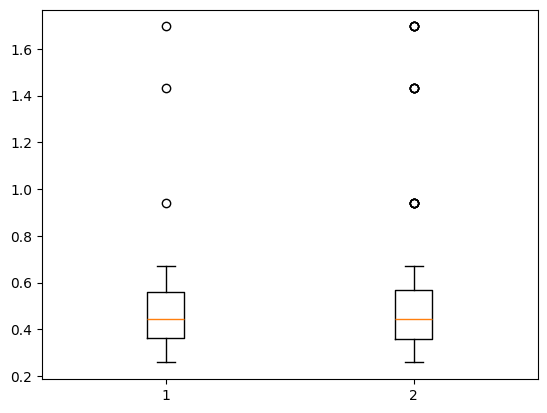

In [100]:
from matplotlib import axis
r =13;
a = fc[:,:,(radii >= r) & (radii <=r+1)]
print(a.shape)
a.cpu().detach().numpy()
x = a[:,0,:]**2 + a[:,1,:]**2
b = interpolate(fc[:,:,(radii >= r) & (radii <=r+1)],256)
y = b[:,0,:]**2 + b[:,1,:]**2
print(x.shape)
x = torch.mean(x,axis =0)
y = torch.mean(y,axis =0)
print(x.shape)
plt.boxplot([x,y])
plt.show()

In [76]:
r =13;
a = fc[:,:,(radii >= r) & (radii <=r+1)][0]
print(torch.mean(a[0,:]**2 + a[1,:]**2))

b = interpolate(fc[:,:,(radii >= r) & (radii <=r+1)],8)[0]
print(torch.mean(b[0,:]**2 + b[1,:]**2))

tensor(0.5730)
tensor(0.8034)


In [34]:
interpolate(fc[:,:,selected_rings],3*a).shape

torch.Size([32, 2, 39])

In [4]:
fc[selected_rings].shape

torch.Size([1536])

In [45]:
data.shape

(100, 100, 100)

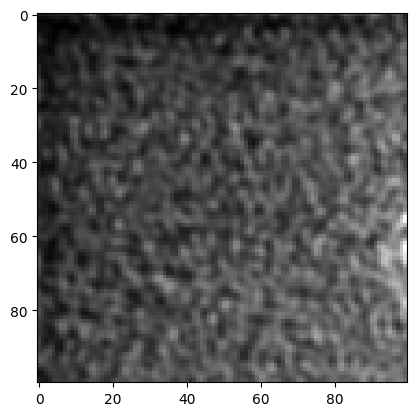

-9147.1016

In [17]:
x = -1000
plt.imshow(gt_img[0,x:x+100,x:x+100], cmap='gray')
plt.show()
gt_img[0,x:x+100,x:x+100].sum()

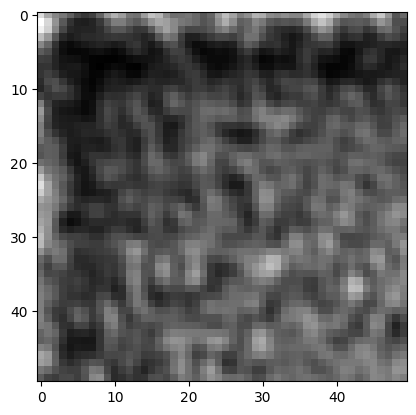

In [29]:
plt.imshow(gt_img[0,:50,:50], cmap='gray')

In [ ]:
# img = torch.zeros([9,9,3])
# points = np.stack(np.indices([9,9])).reshape(2,-1)

# blue = (0,0,1)
# red = (1,0,0)
# orange = (1,1/2,0)
# green = (0,1,0)

# angles = [0,45,225,280]
# origions = np.array([(4,4),(4,4),(4,4),(4,4)])
# colors = [blue, red, orange, green]

# def angle_from(p):
#     return np.rad2deg(np.arctan2(*(points-p.reshape(2,1)))) % 360

# def set_color(angle, origin, color):
#     angles = angle_from(np.array(origin))
#     mask = angles - angle == 0
#     img.view(-1,3)[np.where(mask),:] = torch.tensor(color, dtype=torch.float)

# for angle, origin, color in zip(angles,origions,colors):
#     set_color(angle, origin, color)
#     rad = np.deg2rad(angle)
#     x = (origin[0],origin[1]+10*np.cos(rad))
#     y = (origin[0],origin[1]+10*np.sin(rad))
#     plt.plot(x, y, c='white')
    
# angle = 280
# rad = np.deg2rad(angle)

# plt.scatter(*points)
# plt.imshow(img, origin='lower')

<Figure size 640x480 with 0 Axes>

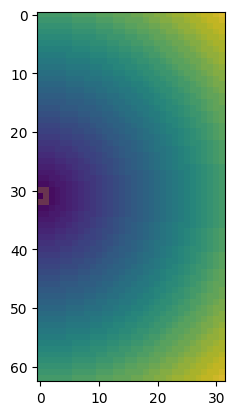

In [74]:

x, y = np.meshgrid(range(model.dft_shape[1]), range(-model.dft_shape[0] // 2 + 1, model.dft_shape[0] // 2 + 1))
radii = np.sqrt(x ** 2 + y ** 2, dtype=np.float32)
# selected_rings = np.round(radii) < num_rings
radii_disc = np.round(radii)
ims = []
fig = plt.figure()
# for n in range(30):
n = 0
fig = plt.figure()
plt.imshow(radii_disc, interpolation='none')
selected_rings = (radii_disc==1)
r = radii_disc.copy()
r[~selected_rings] = 0
im = plt.imshow(r,alpha = 0.2)
    # plt.savefig(f'/home/aman.kukde/Projects/FourierImageTransformer/presentation/output_{n}.png')
    # plt.close()


In [32]:
r[selected_rings]

array([], dtype=float32)

In [ ]:
from fit.utils import read_mrc
import matplotlib.pyplot as plt
import os
import torch
from torchvision.transforms.functional import resize
from torchvision.io import read_image
from tqdm import tqdm

In [ ]:
image_folder_path = '/group/jug/Aman/Omniglot/'
import glob
images = torch.tensor([])
for image_path in tqdm(glob.iglob(image_folder_path + '**/*.png', recursive=True)):
    images = torch.cat([images,read_image(image_path)])
print(images.shape)

0it [00:00, ?it/s]

32460it [32:22, 16.71it/s]

torch.Size([32460, 105, 105])


In [ ]:
torch.save(images,'./Omniglot.pt')

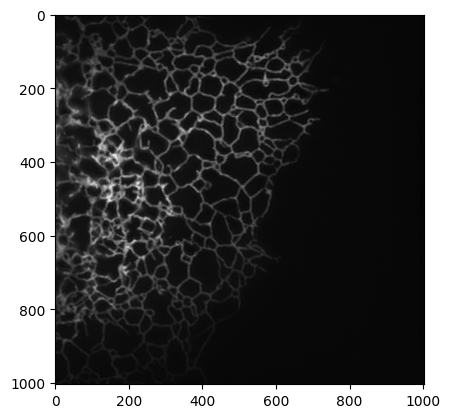

In [38]:
imgs = read_mrc.read_mrc('/group/jug/ashesh/data/BioSR/ER/GT_all.mrc')[1]
imgs = torch.permute(torch.from_numpy(imgs).type(torch.float32),(2,0,1))
# images = resize(imgs, (129, 129),interpolation=0)
plt.imshow(imgs[0],cmap = 'gray')
# plt.imshow(imgs[4,500:629,500:629],cmap = 'gray')


In [ ]:
d_model = 32*2
from transformers import MambaConfig,MambaModel
conf = MambaConfig()
conf.num_hidden_layers = 24
conf.hidden_size = d_model
conf.intermediate_size = d_model*4
encoder = MambaModel(conf)

sum(p.numel() for p in encoder.parameters())/1000000

5.326912

In [2]:
for fc, (mag_min, mag_max) in dm.train_dataloader():
       break

In [ ]:
fc.shape

torch.Size([8, 2016, 2])

In [ ]:
a.shape

torch.Size([8, 2016])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([140, 10])


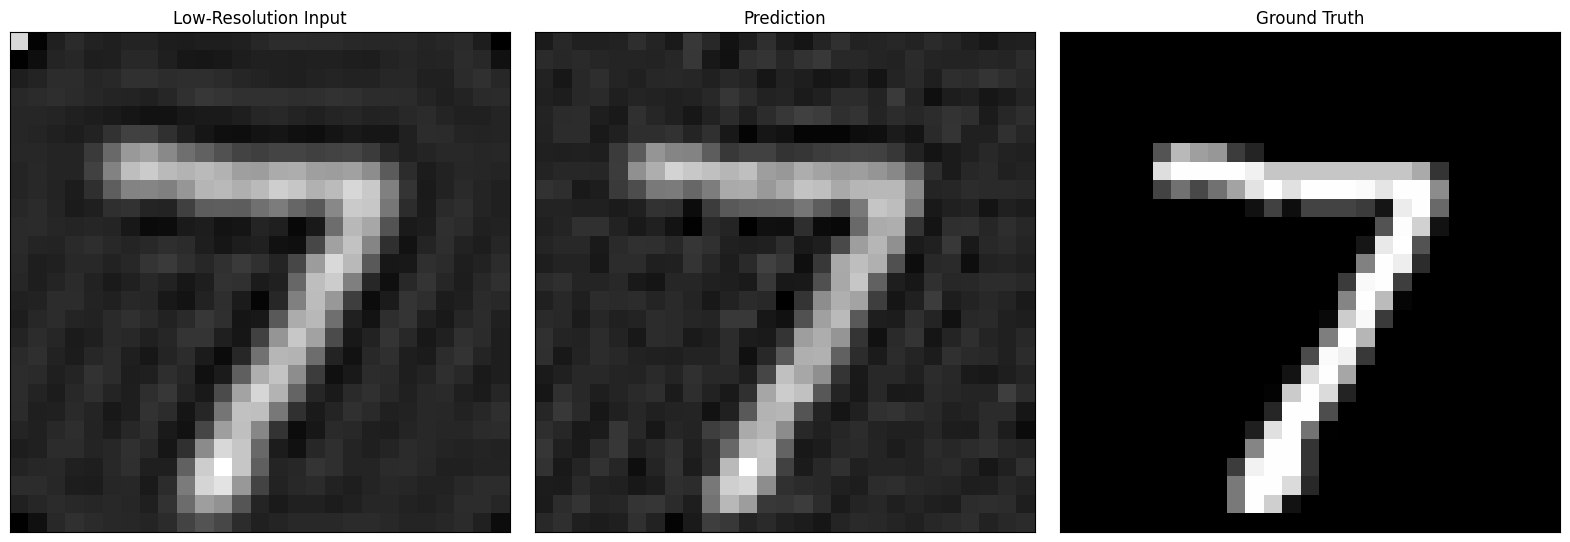

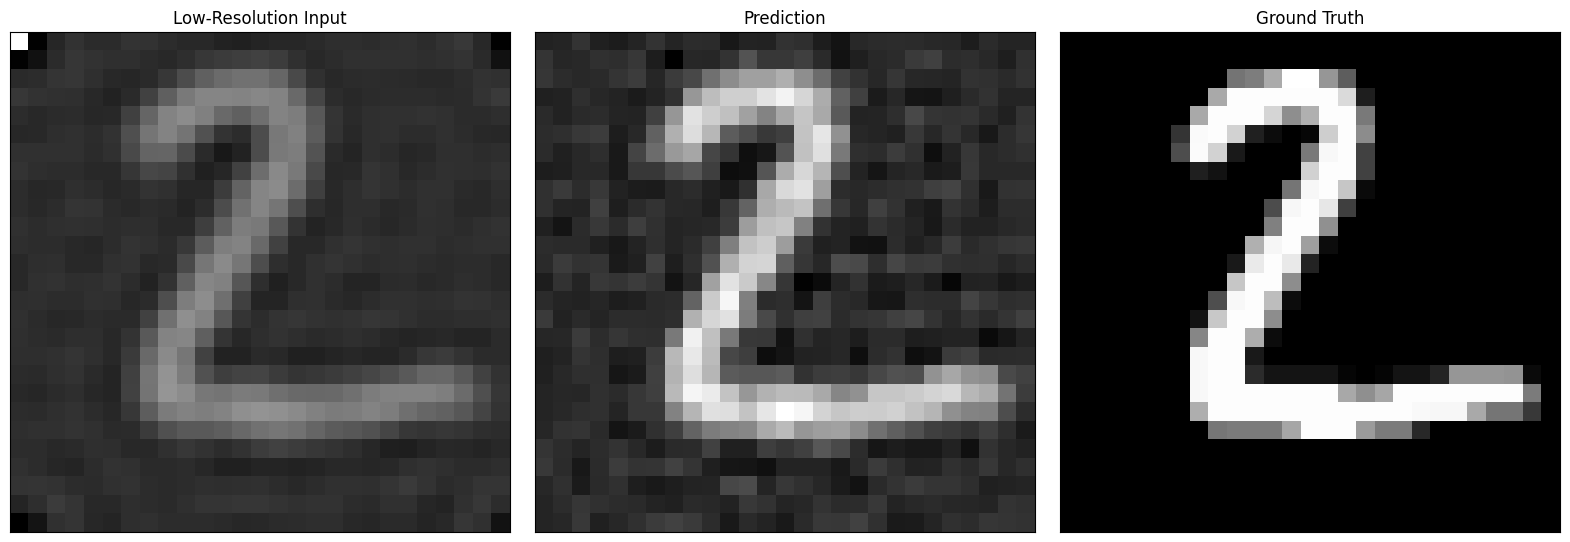

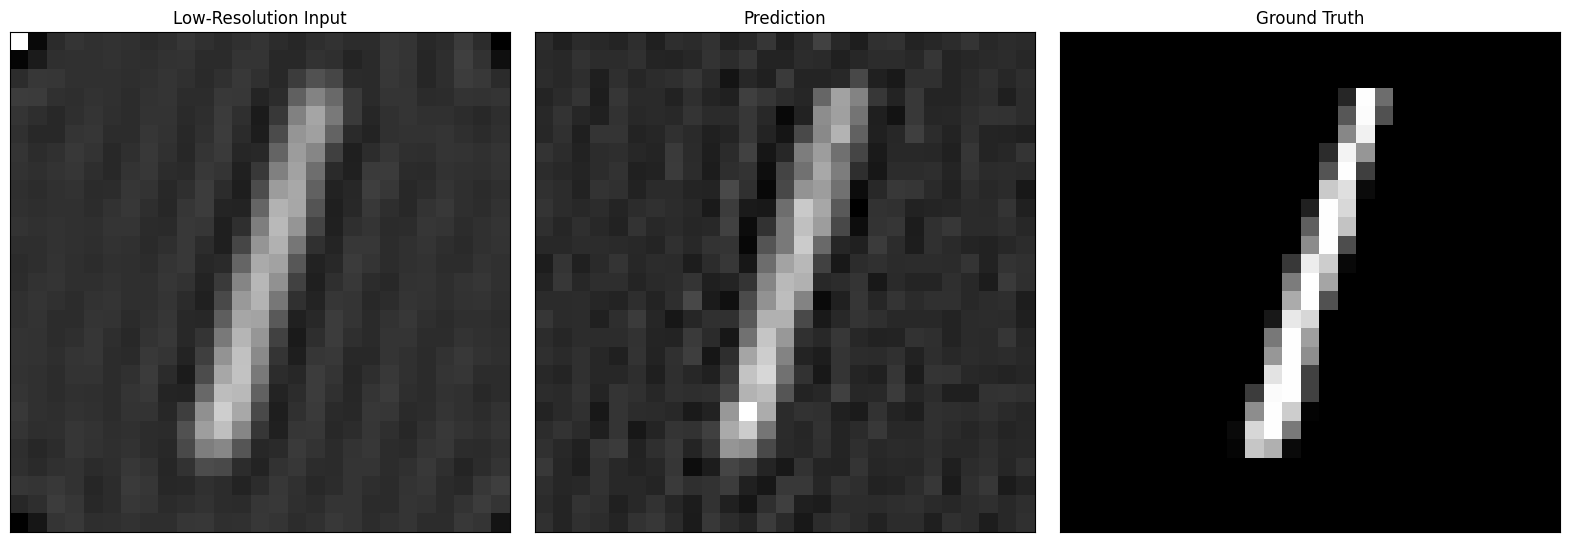

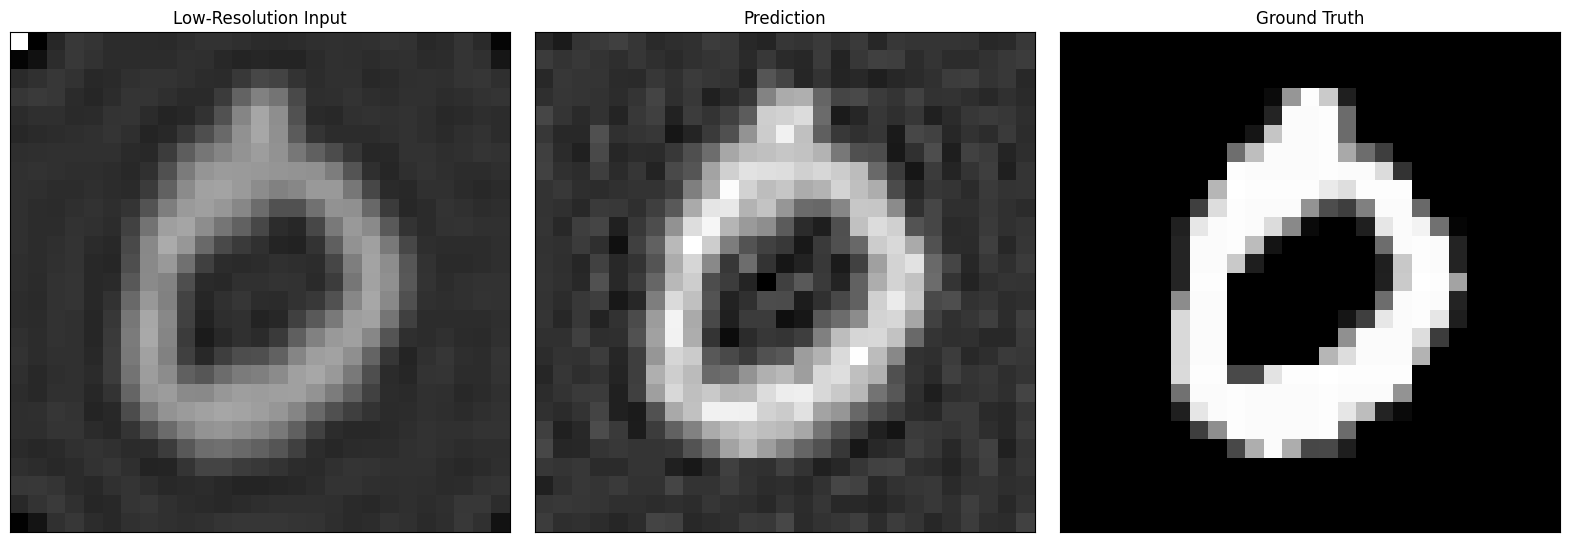

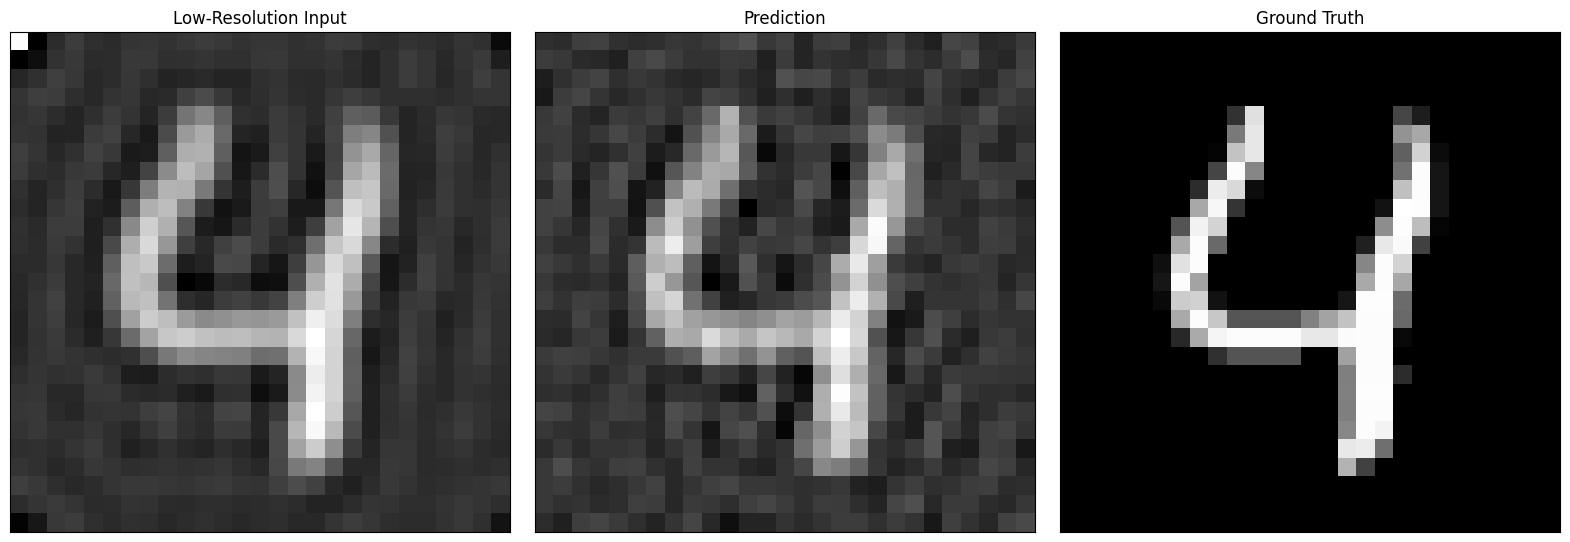

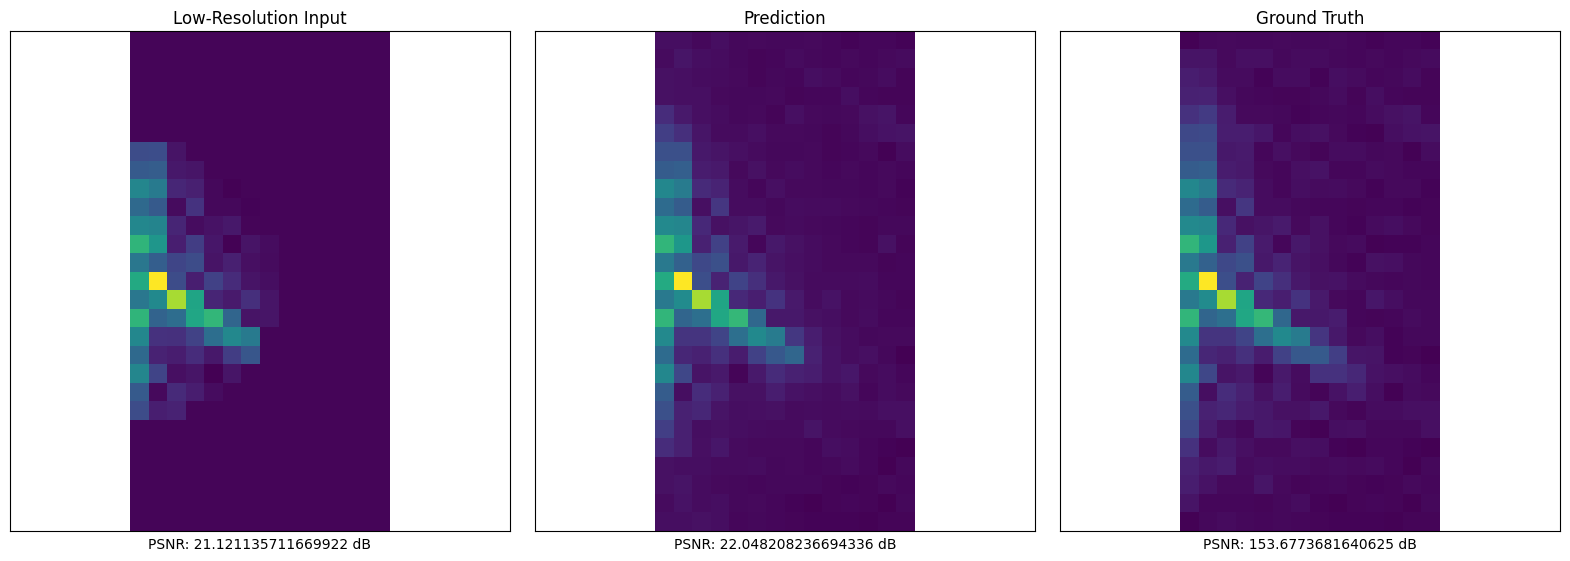

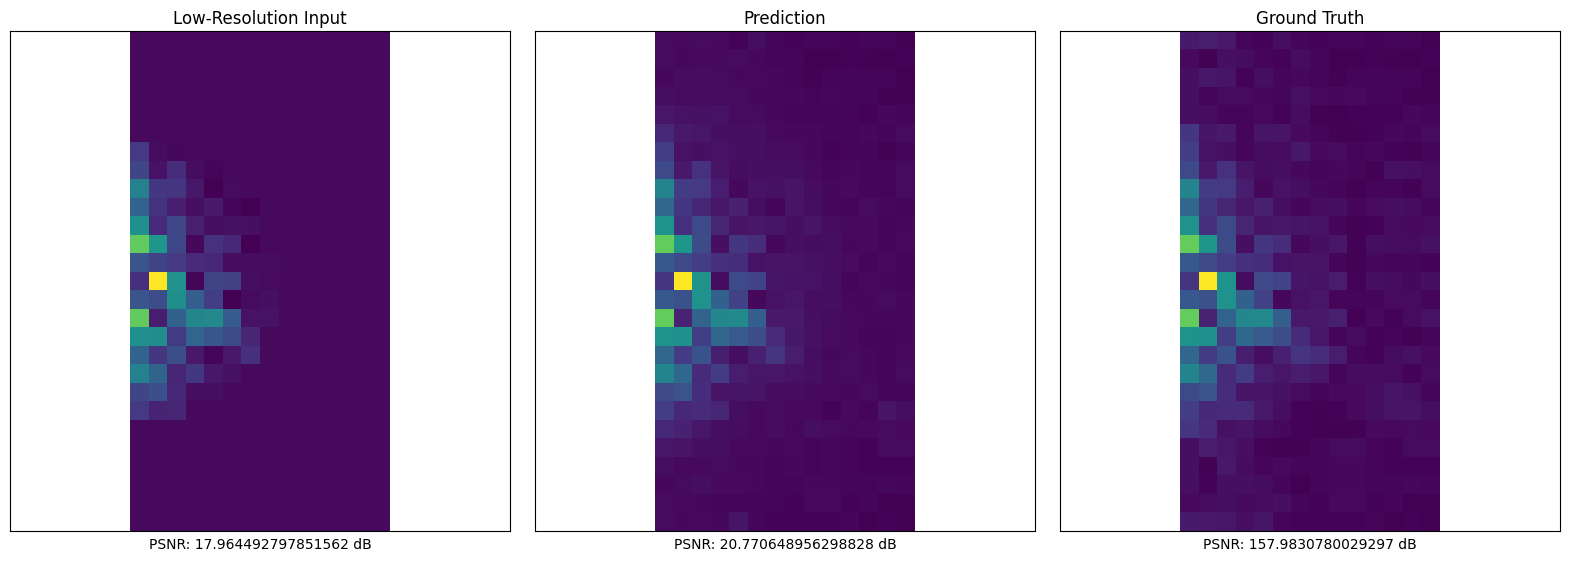

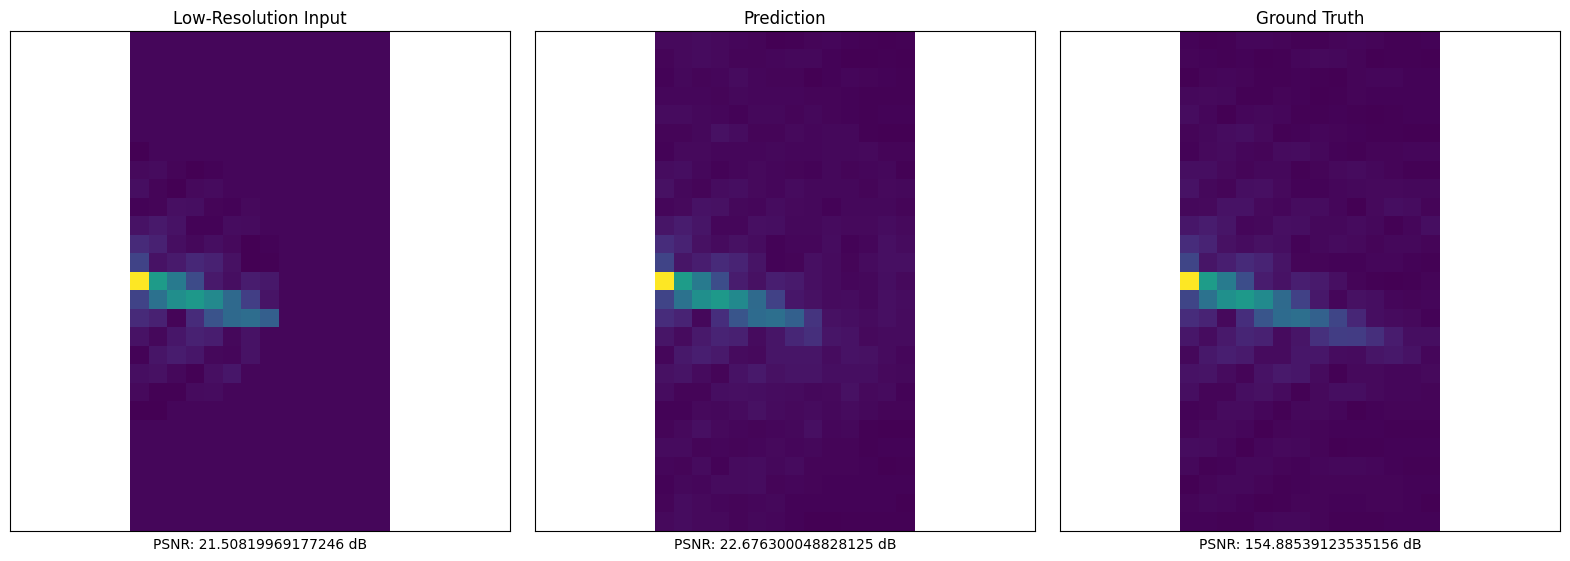

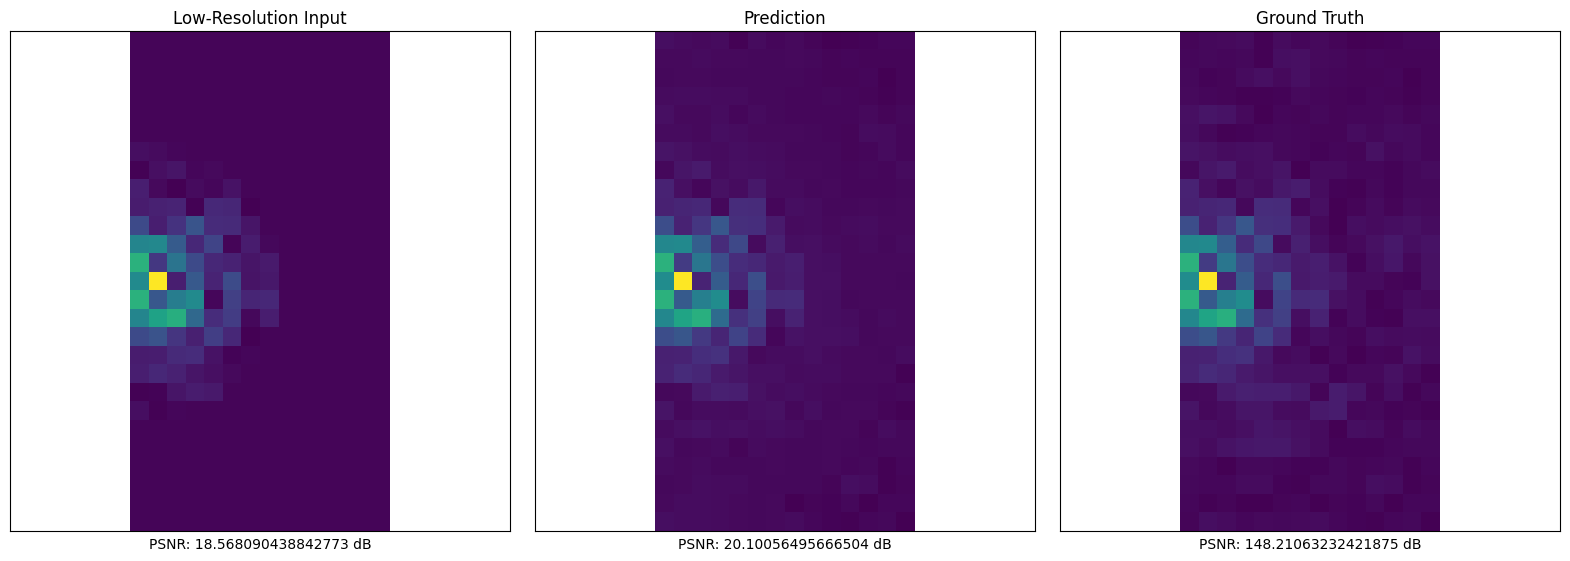

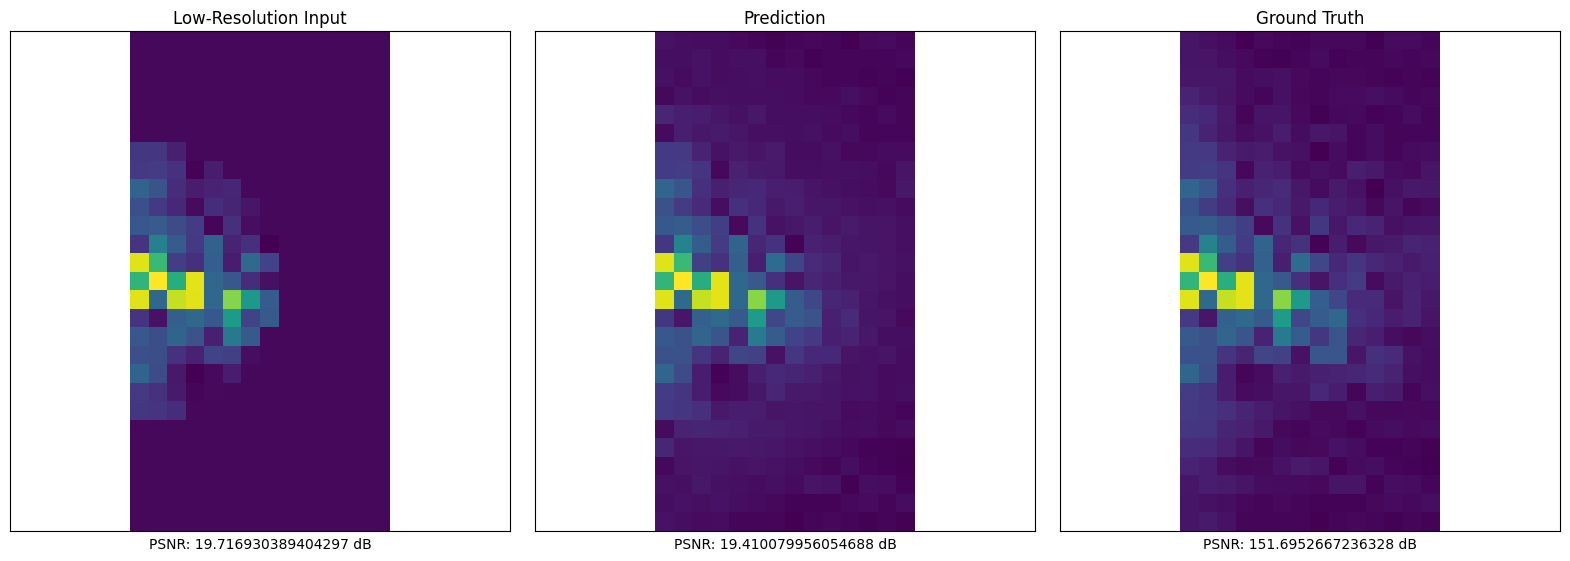

In [9]:
def predict_one_test_batch(no_of_images = 5):
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break

    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_max = mag_max.to('cuda')
    x_input = fc[:, model.dst_flatten_order]


    with torch.no_grad():
        pred = model.sres.forward_inference(x_input,max_seq_length=140)
        # pred = model.sres.forward(x_input)
  
        
    fig = plt.figure()
    lowres = x_input.clone()
    lowres[:, model.input_seq_length:] = 0
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)



    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)
    gt_psnr = PSNR(gt_img,gt_img)

    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True )
    fig.legend()
    plt.savefig('psnr_diff.png')
    plt.close()
    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    for sample in range(no_of_images):
        fig2 = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1,5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.set_title('Low-Resolution Input');
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(pred_img[sample].cpu(), cmap='gray')
        ax1.set_title('Prediction');
        ax1.axis('equal');


        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(gt_img[sample].cpu(), cmap='gray')
        ax2.set_title('Ground Truth');
        ax2.axis('equal');

    from sklearn.random_projection import sample_without_replacement


    for i in range(no_of_images):
        sample = i
        fig = plt.figure(figsize=(31/2., 10/2.))
        gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10])
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[2])
        ax2 = plt.subplot(gs[4])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
                            hspace = 0, wspace = 0)
        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        lowres_psnr = PSNR(gt_img, lowres_img)
        ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2 ,0))
        ax0.set_title('Low-Resolution Input');
        ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
        ax0.axis('equal');

        ax1.xaxis.set_major_locator(plt.NullLocator())
        ax1.yaxis.set_major_locator(plt.NullLocator())
        ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        pred_psnr = PSNR(gt_img, pred_img)
        ax1.set_title('Prediction');
        ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
        ax1.axis('equal');

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),model.dft_shape[0] // 2,0))
        ax2.set_title('Ground Truth');
        ax2.set_xlabel(f'PSNR: {gt_psnr[sample].cpu().detach()} dB')
        ax2.axis('equal');

predict_one_test_batch(5)